<a href="https://colab.research.google.com/github/sameh00alsharawy/emotion-detection-fer2013/blob/main/emotion_detection_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!pip install keras-vggface


TensorFlow 1.x selected.


In [2]:
import numpy as np
from skimage.transform import resize
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

import tensorflow as tf 

import keras
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace

import zipfile

from keras.utils import to_categorical


Using TensorFlow backend.


In [3]:
print(tf.__version__)
print(keras.__version__)


1.15.2
2.3.1


In [4]:
 ! pip install -q kaggle

In [5]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samehalsharawy","key":"998cf947154a5776bc5cbf887a38c2ab"}'}

In [6]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 5.46MB/s]
 97% 75.0M/77.3M [00:00<00:00, 220MB/s]
100% 77.3M/77.3M [00:00<00:00, 258MB/s]
 98% 90.0M/92.0M [00:00<00:00, 214MB/s]
100% 92.0M/92.0M [00:00<00:00, 232MB/s]
 52% 10.0M/19.3M [00:00<00:00, 105MB/s]
100% 19.3M/19.3M [00:00<00:00, 121MB/s]
 99% 96.0M/96.6M [00:00<00:00, 228MB/s]
100% 96.6M/96.6M [00:00<00:00, 244MB/s]


In [8]:
!pwd
!ls

/content
example_submission.csv	icml_face_data.csv.zip	sample_data   train.csv.zip
fer2013.tar.gz		kaggle.json		test.csv.zip


In [9]:
lz = 'icml_face_data.csv.zip'
with zipfile.ZipFile(lz, 'r') as zip_ref:
    zip_ref.extractall()


In [10]:
data= pd.read_csv('icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [11]:
data.columns = ['emotion', 'usage', 'pixels']

In [12]:
data['usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: usage, dtype: int64

In [ ]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [13]:
def prepare_data (df):
  n = df.shape[0]
  x = np.zeros((n, 48, 48, 3))
  y = df.emotion.values
  for i in range(n):
    img=np.array([float (x) for x in  df.pixels.values[i].split(' ')]).reshape(48,48)
    for j in range(3):
      x[i,:,:,j] =img
  return x,y 

In [14]:
x_train, y_train = prepare_data(data[data.usage == "Training"])
x_val,   y_val   = prepare_data(data[data.usage == "PrivateTest"])
x_test,  y_test  = prepare_data(data[data.usage == "PublicTest"])

In [15]:
train_labels = to_categorical(y_train)
val_labels   = to_categorical(y_val)
test_labels  = to_categorical(y_test)
# x_test = x_test/255.0
# x_train= x_train/255.0
# x_val  = x_val/255.0

In [ ]:
x_train.shape

(28709, 48, 48, 3)

In [16]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [17]:
def get_datagen(x, y, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow(
            x, 
            y=y,
            shuffle = True,
            batch_size=256 
            )


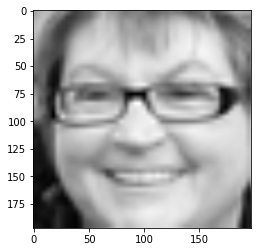

In [ ]:
plt.imshow(resize(x_test[100][:, :, 2], (197,197)), cmap='gray')

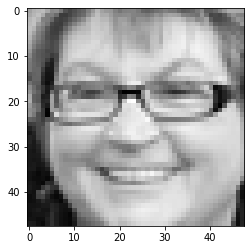

In [ ]:
plt.imshow(x_test[100][:,:,2], cmap='gray')

In [18]:
train_generator  = get_datagen(x_train, train_labels, True)
val_generator    = get_datagen(x_val, val_labels)
test_generator  = get_datagen(x_test, test_labels)

In [ ]:
vgg = VGGFace(include_top=False, model = 'vgg16', weights='vggface', input_shape=(197,197,3))
vgg.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 197, 197, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98, 98, 128)       147584    
_____________________________________

In [ ]:
for layer in vgg.layers:
  layer.trainable =False


last_layer = vgg.get_layer('pool5').output
x = Flatten()(last_layer)

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

out = Dense(7, activation='softmax')(x)

model = keras.Model(vgg.input, out)

original_dim = (48, 48, 3)
target_size = (197,197)

input = keras.layers.Input(original_dim)
y = keras.layers.Lambda(lambda image: tf.image.resize(image, target_size))(input)
y = model(inputs=y)
wrapper_model = keras.Model(input, y)

wrapper_model.compile( 
    optimizer = 'adam', 
    loss = keras.losses.categorical_crossentropy, 
    metrics = ['accuracy']
)

In [ ]:
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=5, min_lr=0.00001, verbose=1)

history=wrapper_model.fit_generator( 
    train_generator,
    steps_per_epoch = 28709//256,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = 3589//256,
    shuffle = False, 
    callbacks=[rlrop]
)

Epoch 1/10
112/112 [==============================] - 143s 1s/step - loss: 1.3681 - accuracy: 0.5109 - val_loss: 1.0976 - val_accuracy: 0.5957
Epoch 2/10
112/112 [==============================] - 126s 1s/step - loss: 1.1137 - accuracy: 0.5878 - val_loss: 0.9520 - val_accuracy: 0.6301
Epoch 3/10
112/112 [==============================] - 123s 1s/step - loss: 1.0306 - accuracy: 0.6119 - val_loss: 0.9934 - val_accuracy: 0.6505
Epoch 4/10
112/112 [==============================] - 123s 1s/step - loss: 0.9673 - accuracy: 0.6366 - val_loss: 0.9271 - val_accuracy: 0.6697
Epoch 5/10
112/112 [==============================] - 122s 1s/step - loss: 0.9347 - accuracy: 0.6515 - val_loss: 0.7809 - val_accuracy: 0.6493
Epoch 6/10
112/112 [==============================] - 123s 1s/step - loss: 0.8993 - accuracy: 0.6614 - val_loss: 0.9677 - val_accuracy: 0.6586
Epoch 7/10
112/112 [==============================] - 123s 1s/step - loss: 0.8776 - accuracy: 0.6724 - val_loss: 0.9058 - val_accuracy: 0.6511

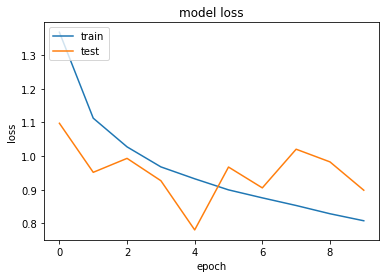

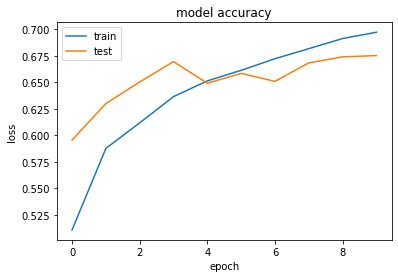

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
wrapper_model.save('model_tl_1.h5')

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
 ! cp model_tl_1.h5 /content/gdrive/MyDrive

In [23]:
target_size = (197,197)

In [24]:
model = keras.models.load_model('/content/gdrive/MyDrive/model_tl_1.h5',
                                custom_objects={'tf': tf, 'target_size':target_size})

In [27]:
model.compile( 
    optimizer = keras.optimizers.adam(learning_rate=0.0001), 
    loss = keras.losses.categorical_crossentropy, 
    metrics = ['accuracy']
)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max', 
                                          factor=0.5, patience=5, min_lr=0.00001, verbose=1)

history=model.fit_generator( 
    train_generator,
    steps_per_epoch = 28709//256,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = 3589//256,
    shuffle = False, 
    callbacks=[rlrop]
)

Epoch 1/10
112/112 [==============================] - 126s 1s/step - loss: 0.6548 - accuracy: 0.7573 - val_loss: 0.8636 - val_accuracy: 0.6867
Epoch 2/10
112/112 [==============================] - 123s 1s/step - loss: 0.6462 - accuracy: 0.7594 - val_loss: 1.1025 - val_accuracy: 0.6925
Epoch 3/10
112/112 [==============================] - 123s 1s/step - loss: 0.6418 - accuracy: 0.7598 - val_loss: 0.9517 - val_accuracy: 0.6856
Epoch 4/10
112/112 [==============================] - 123s 1s/step - loss: 0.6343 - accuracy: 0.7672 - val_loss: 0.9372 - val_accuracy: 0.6976
Epoch 5/10
112/112 [==============================] - 123s 1s/step - loss: 0.6206 - accuracy: 0.7714 - val_loss: 0.8936 - val_accuracy: 0.7015
Epoch 6/10
112/112 [==============================] - 123s 1s/step - loss: 0.6113 - accuracy: 0.7751 - val_loss: 0.9325 - val_accuracy: 0.6958
Epoch 7/10
112/112 [==============================] - 123s 1s/step - loss: 0.6092 - accuracy: 0.7752 - val_loss: 0.9269 - val_accuracy: 0.7042

In [29]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 197, 197, 3)       0         
_________________________________________________________________
model_4 (Model)              (None, 7)                 34124615  
Total params: 34,124,615
Trainable params: 19,406,855
Non-trainable params: 14,717,760
_________________________________________________________________


In [52]:
model.layers[-1].summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 197, 197, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98, 98, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 49, 49, 128)       0   

In [36]:
for i in [11,12,13,15,16,17]:
  model.layers[-1].layers[i].trainable = True

In [37]:
model.compile( 
    optimizer = keras.optimizers.adam(learning_rate=0.0001), 
    loss = keras.losses.categorical_crossentropy, 
    metrics = ['accuracy']
)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max', 
                                          factor=0.5, patience=10, min_lr=0.00001, verbose=1)

history=model.fit_generator( 
    train_generator,
    steps_per_epoch = 28709//256,
    epochs = 100,
    validation_data = val_generator,
    validation_steps = 3589//256,
    shuffle = False, 
    callbacks=[rlrop]
)

Epoch 1/100
112/112 [==============================] - 164s 1s/step - loss: 0.7274 - accuracy: 0.7286 - val_loss: 1.0463 - val_accuracy: 0.6867
Epoch 2/100
112/112 [==============================] - 161s 1s/step - loss: 0.6548 - accuracy: 0.7574 - val_loss: 0.9377 - val_accuracy: 0.6892
Epoch 3/100
112/112 [==============================] - 160s 1s/step - loss: 0.6108 - accuracy: 0.7757 - val_loss: 0.9325 - val_accuracy: 0.7021
Epoch 4/100
112/112 [==============================] - 159s 1s/step - loss: 0.5717 - accuracy: 0.7861 - val_loss: 0.8449 - val_accuracy: 0.6952
Epoch 5/100
112/112 [==============================] - 160s 1s/step - loss: 0.5397 - accuracy: 0.8017 - val_loss: 1.0147 - val_accuracy: 0.6934
Epoch 6/100
112/112 [==============================] - 160s 1s/step - loss: 0.5022 - accuracy: 0.8155 - val_loss: 0.9016 - val_accuracy: 0.7009
Epoch 7/100
112/112 [==============================] - 160s 1s/step - loss: 0.4850 - accuracy: 0.8222 - val_loss: 0.8526 - val_accuracy:

KeyboardInterrupt: ignored

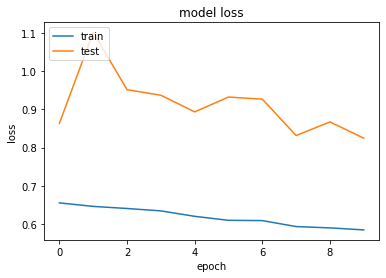

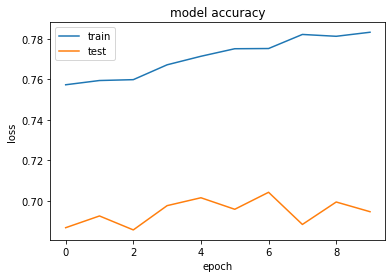

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
model.compile( 
    optimizer = keras.optimizers.adam(learning_rate=0.00001), 
    loss = keras.losses.categorical_crossentropy, 
    metrics = ['accuracy']
)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max', 
                                          factor=0.5, patience=10, min_lr=0.00001, verbose=1)

history=model.fit_generator( 
    train_generator,
    steps_per_epoch = 28709//256,
    epochs = 3,
    validation_data = val_generator,
    validation_steps = 3589//256,
    shuffle = False, 
    callbacks=[rlrop]
)

Epoch 1/3
112/112 [==============================] - 162s 1s/step - loss: 0.1048 - accuracy: 0.9669 - val_loss: 1.2610 - val_accuracy: 0.7268
Epoch 2/3
112/112 [==============================] - 159s 1s/step - loss: 0.0961 - accuracy: 0.9702 - val_loss: 1.3412 - val_accuracy: 0.7243
Epoch 3/3
112/112 [==============================] - 159s 1s/step - loss: 0.0894 - accuracy: 0.9718 - val_loss: 1.3002 - val_accuracy: 0.7264


In [40]:
model.evaluate_generator(test_generator)

[1.4374473094940186, 0.707996666431427]

In [41]:
model.save('/content/gdrive/MyDrive/model_tl_ft.hdf5')

In [42]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 197, 197, 3)       0         
_________________________________________________________________
model_4 (Model)              (None, 7)                 34124615  
Total params: 34,124,615
Trainable params: 32,386,055
Non-trainable params: 1,738,560
_________________________________________________________________


In [53]:
input = keras.layers.Input(shape=(197, 197, 3))
first_layer = model.get_layer(index=2).get_layer('input_1').input
last_layer = model.get_layer(index=2).get_layer('dense_9').output
final_model = keras.Model(first_layer, last_layer)

In [54]:
final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 197, 197, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98, 98, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 49, 49, 128)       0   

In [70]:
final_model.compile( 
    optimizer='adam',
    metrics=['accuracy'],
    loss = keras.losses.categorical_crossentropy
)

In [90]:
new_x_test = np.zeros(shape = (x_test.shape[0], 197, 197, 3))
for ix in range(x_test.shape[0]):
  img =resize(x_test[ix], (197,197, 3))
  new_x_test[ix, :, :, :] = img
  

In [92]:
final_model.evaluate(x=new_x_test, y=test_labels, batch_size=1)

3589/3589 [==============================] - 34s 10ms/step


[129.17546394818498, 0.6868208646774292]

In [93]:
final_model.save('/content/gdrive/MyDrive/model_197.hdf5')